In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

cuda = torch.cuda.is_available()
cuda

False

In [31]:
path = "C:\\Users\\cheth\\OneDrive\\Documents\\DeepLearning\\HW1\\Part2\\11-785hw1p2-f19.tar\\11-785hw1p2-f19\\11-785hw1p2-f19"

x = np.load(path+"\\dev.npy", allow_pickle = True)
y = np.load(path+"\\dev_labels.npy",allow_pickle = True )

print(y.shape)
print(y[0].shape)
print(y[0][0])

(1100,)
(625,)
108


In [ ]:
k= 1
feature_length = 40

#final_input = np.zeros((1,(((2*k) + 1) * feature_length)), dtype = float)

f = open('dev_input.txt', 'w')
f.close()

total_length = 0

with open('dev_input.txt', 'a+') as outfile:
    for i in range(len(x)):
        #print(i)
        utterance_length = x[i].shape[0]
        total_length = total_length + utterance_length        
        zero_padding = np.zeros((k,40), dtype = float)
        input_tmp = np.append(zero_padding,x[i], axis = 0 )
        input = np.append(input_tmp,zero_padding, axis = 0 )
        flat_utterance = input.flatten()
    
        for j in range(utterance_length):
            tmp1 = flat_utterance[(j*feature_length) : ((((2*k) + 1) * feature_length) + (j*feature_length))]
            tmp2 = tmp1.reshape(1,(((2*k) + 1) * feature_length))
            np.savetxt(outfile,tmp2)
            

with open('dev_labels.txt', 'a+') as outfile:
    for i in range(len(y)):
        print(i)
        utterance_length = y[i].shape[0]
    
        for j in range(utterance_length):
            np.savetxt(outfile,np.array([y[i][j]]))  

In [2]:
dev_data = np.loadtxt('dev_input.txt', delimiter=' ')
print(dev_data.shape)

(675836, 120)


In [3]:
dev_labels = np.loadtxt('dev_labels.txt', delimiter=' ')
print(dev_labels.shape)

(675836,)


In [20]:
dev_data_torch = torch.tensor(dev_data, dtype = torch.float)

In [21]:
dev_labels_torch = torch.tensor(dev_labels, dtype = torch.long)

In [12]:
class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = self.X[index] #flatten the input
        Y = self.Y[index]
        return X,Y

In [22]:
num_workers = 0 if sys.platform == 'win32' else 2
    
# Training
train_dataset = MyDataset(dev_data_torch, dev_labels_torch)

train_loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Testing
#test_dataset = MyDataset(test.data, test.targets)

test_dataset = MyDataset(dev_data_torch, dev_labels_torch)

test_loader_args = dict(shuffle=False, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

In [23]:
# SIMPLE MODEL DEFINITION
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [24]:
model = Simple_MLP([120, 40, 138])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=120, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=138, bias=True)
  )
)


In [25]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.to(device)

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [26]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [27]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

Training Loss:  3.6969856057203176 Time:  25.7490074634552 s
Testing Loss:  3.3326930831861703
Testing Accuracy:  21.92854479489107 %
Training Loss:  3.1772812677378006 Time:  30.85515570640564 s
Testing Loss:  3.173152941182673
Testing Accuracy:  24.49573565184453 %
Training Loss:  3.1202179962261156 Time:  30.59987998008728 s
Testing Loss:  3.165633770898519
Testing Accuracy:  23.662397386348168 %
Training Loss:  3.0941799758961706 Time:  29.989518404006958 s
Testing Loss:  3.0633400600920866
Testing Accuracy:  24.74712800146781 %
Training Loss:  3.069237320983049 Time:  31.42664861679077 s
Testing Loss:  3.0343963473942925
Testing Accuracy:  26.123201486751224 %
Training Loss:  3.0493419998297187 Time:  30.74669122695923 s
Testing Loss:  3.033871616457128
Testing Accuracy:  25.359702649755267 %
Training Loss:  3.0383343567225065 Time:  31.5475013256073 s
Testing Loss:  3.126314701721434
Testing Accuracy:  23.78520824578744 %
Training Loss:  3.0253705221595184 Time:  29.5735831260681

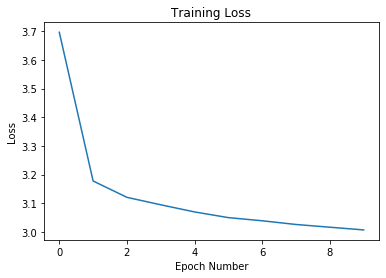

In [28]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

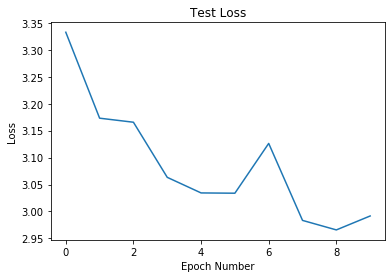

In [29]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)

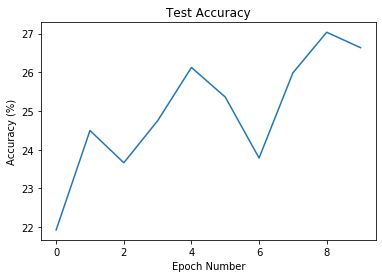

In [30]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)

